### Ritajit Majumdar
Enabling Quantum Technologies Researcher @ IBM Quantum

### ZNE with partial folding to obtain competitive expectation values for deep circuits

Zero Noise Extrapolation (ZNE) is an error mitigation technique used to obtain expectation values closer to the ideal noiseless value from a noisy quantum computer. ZNE can be classified broadly into - (i) analog ZNE, and (ii) digital ZNE. Digital ZNE is performed by folding the gates in the circuit, or by appending learned noise at the end of each layer, called Probabilistic Error Amplification (PEA).

In this notebook we select digital ZNE via folding primarily because it has a much simpler implementation than analog ZNE (<a href='https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509'>Physical review letters, 119(18), 180509</a>), and does not require the time consuming $learning$ step of PEA (<a href='https://www.nature.com/articles/s41586-023-06096-3'>Nature, 618(7965), 500-505</a>). Henceforth, the term $digital ZNE$ or $ZNE$ will imply digital ZNE via folding.

The general idea of digital ZNE (dZNE) is to replace some gates $U$ by $U(U^{\dagger}U)^{f}$ for some $\lambda = 2f+1$, $f \geq 0$. This ensures that the functionality of the circuit remains unchanged (since $U^{\dagger}U = I$), however, the noise is increased due to the increased number of gates. The expectation values are obtained for different values of $\lambda$, and then extrapolated to $\lambda = 0$ to obtain an estimate of the expectation value in zero noise limit.

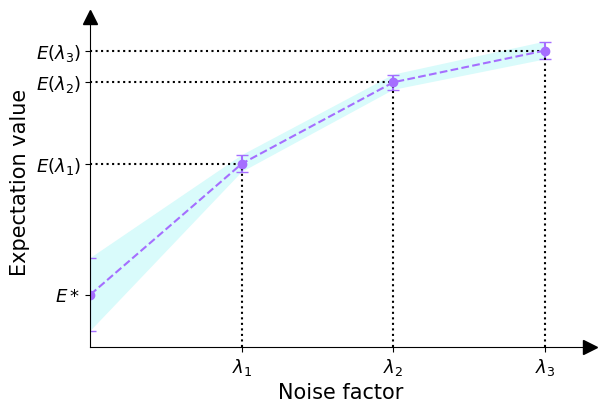

### 1. Map circuit to quantum hardware native form

For this study we consider a QAOA path circuit. <a href='https://arxiv.org/abs/1411.4028'>QAOA</a> is a variational algorithm to find approximate solutions to combinatorial optimization problems. Any combinatorial optimization problem can be represented as a graph. Here we consider the graph to be a path graph. Such a graph is essentially a 1D chain (i.e., a tree), and is therefore native to the hardware.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


class QAOAPathCircuit(QuantumCircuit):
    """Parameterized QAOA acyclic line graph quantum circuit.

    The cost parameter-vector is labeled γ, and the mixer
    parameter-vector β. Overall, there will be one parameter per
    unit of two-qubit depth: half in γ and half in ß [1].
    Weights in the generating max-cut graph are all equal to one.

    Args:
        num_qubits: number of qubits (must be even).
        depth: two-qubit depth (must be even).
        barriers: if True adds barriers between layers.
        measurements: if True adds measurements at the end.

    Notes:
        [1] Farhi et.al. A Quantum Approximate Optimization Algorithm,
            https://arxiv.org/abs/1411.4028
    """

    def __init__(
        self, num_qubits: int, depth: int, *, barriers: bool = False, measurements: bool = False
    ) -> None:
        num_qubits = _validate_qaoa_num_qubits(num_qubits)
        depth = _validate_qaoa_depth(depth)
        barriers = bool(barriers)
        measurements = bool(measurements)

        super().__init__(num_qubits, name=f"QAOAPathCircuit<{num_qubits}, {depth}>")

        gammas = ParameterVector("γ", depth // 2)
        betas = ParameterVector("β", depth // 2)

        self.h(range(num_qubits))
        for layer in range(depth // 2):
            if barriers:
                self.barrier()
            for qubit in range(0, num_qubits - 1, 2):
                self.rzz(gammas[layer], qubit, qubit + 1)
            for qubit in range(1, num_qubits - 1, 2):
                self.rzz(gammas[layer], qubit, qubit + 1)
            for qubit in range(num_qubits):
                self.rx(betas[layer], qubit)
        if measurements:
            self.measure_all()


def _validate_qaoa_num_qubits(num_qubits: int) -> int:
    """Validate number of qubits for QAOA circuits."""
    # pylint: disable=duplicate-code
    if not isinstance(num_qubits, int):
        raise TypeError(f"Invalid num. qubits type {type(num_qubits)}, expected <int>.")
    if num_qubits <= 2:
        raise ValueError(f"Number of qubits ({num_qubits}) must be greater than two.")
    if num_qubits % 2:
        raise ValueError(f"Number of qubits ({num_qubits}) must be even.")
    return num_qubits


def _validate_qaoa_depth(depth: int) -> int:
    """Validate depth for QAOA circuits."""
    # pylint: disable=duplicate-code
    if not isinstance(depth, int):
        raise TypeError(f"Invalid depth type {type(depth)}, expected <int>.")
    if depth < 0:
        raise ValueError(f"Depth ({depth}) must be positive.")
    if depth % 2:
        raise ValueError(f"Depth ({depth}) must be even.")
    return depth

In this notebook we shall use the small example of 6-qubit p=1 $reference\_circuit$ to explain the steps for the ease of understanding. The original circuit, on which the experimentations will be performed will be termed $virtual\_circuit$.

The circuit construction considers $depth = 2p$ since the QAOA circuit for each $p$ consists of two 2-qubit layers.

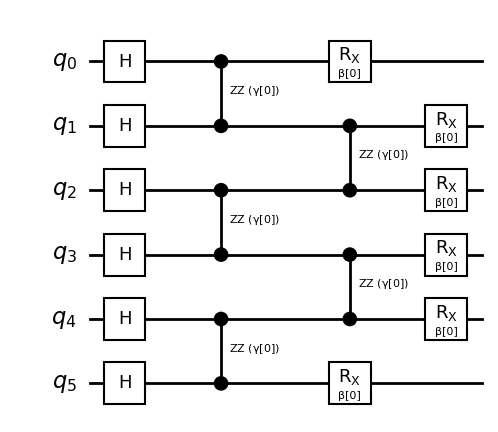

In [2]:
reference_circuit = QAOAPathCircuit(6,2)
reference_circuit.draw('mpl', style='bw', fold=-1)

#### Mirror circuit: the compute-uncompute pattern

A compute-uncompute circuit appends the inverse of the circuit unitary to the circuit, so that ideally the outcome is $|0\rangle^n$, $n$ being the number of qubits. Having a compute-uncompute circuit removes the need of simulating the ideal outcome for verification. However, having a compute-uncompute type circuit also doubles the depth.

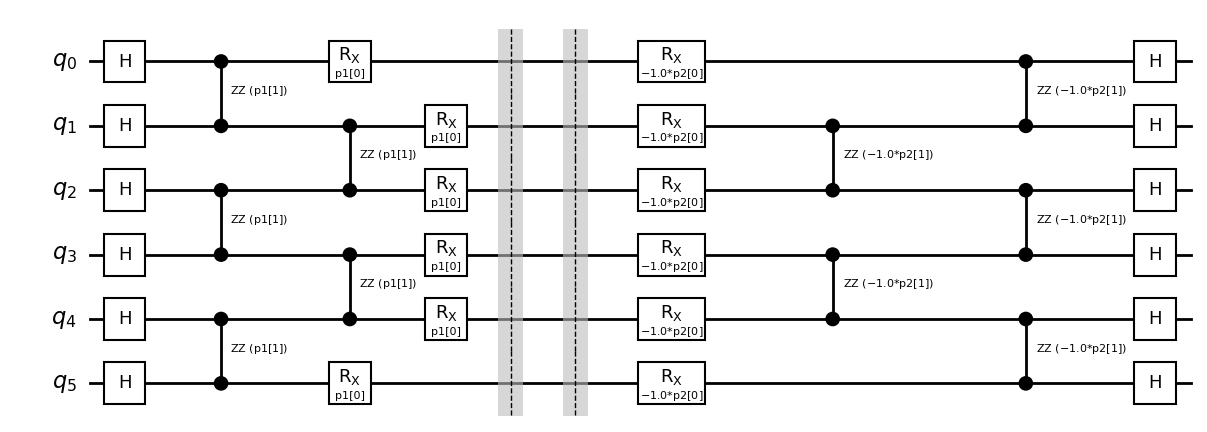

In [3]:
from qiskit.circuit.library import UnitaryOverlap

reference_circuit.barrier()
reference_circuit = UnitaryOverlap(reference_circuit, reference_circuit)

reference_circuit.draw("mpl", style="bw")

Notice that Qiskit requires a barrier between the compute and uncompute parts of the circuit in order to avoid simplification of the circuit to identity during transpilation.

In [4]:
def adds_two_qubit_depth(instruction):
    """Returns True if the instruction adds two-qubit depth, False otherwise."""
    if instruction.operation.name == "barrier":
        return False
    return instruction.operation.num_qubits > 1

depth = reference_circuit.depth(adds_two_qubit_depth)  # Original depth = 2
print(f">> Compute-uncompute 2-qubit depth: {depth} (= 2 x 2)")

>> Compute-uncompute 2-qubit depth: 4 (= 2 x 2)


For our experimentation, we shall consider a 40 qubit $p = 5$ QAOA circuit. Note that the depth of the circuit is twice the value of $p$.

In [5]:
p = 5
virtual_circuit = QAOAPathCircuit(40,2*p)

Now, we shall assign the parameters. For each layer $p$, a QAOA circuit has one parameter $\gamma$ and one parameter $\beta$. Therefore, the total number of parameters is $2p$.

In [6]:
from numpy.random import default_rng
from numpy import pi

rng = default_rng(seed=0)

gamma = rng.uniform(-pi, pi, size=p).tolist()
beta = rng.uniform(-pi, pi, size=p).tolist()

print("PARAMETERS:")
print(f"γ:= {gamma}")
print(f"β:= {beta}")

PARAMETERS:
γ:= [0.8605556614246863, -1.4464727375963786, -2.8841484100105235, -3.03774645687452, 1.9683349641197863]
β:= [2.5934197786078093, 0.6700123395200417, 1.441969420022903, 0.27410390540137985, 2.7336406607023154]


In [7]:
params = []

for i in range(p):
    params.append(gamma[i])
    params.append(beta[i])

virtual_circuit.assign_parameters(params, inplace=True)

Now we create the compute-uncompute version of the virtual circuit

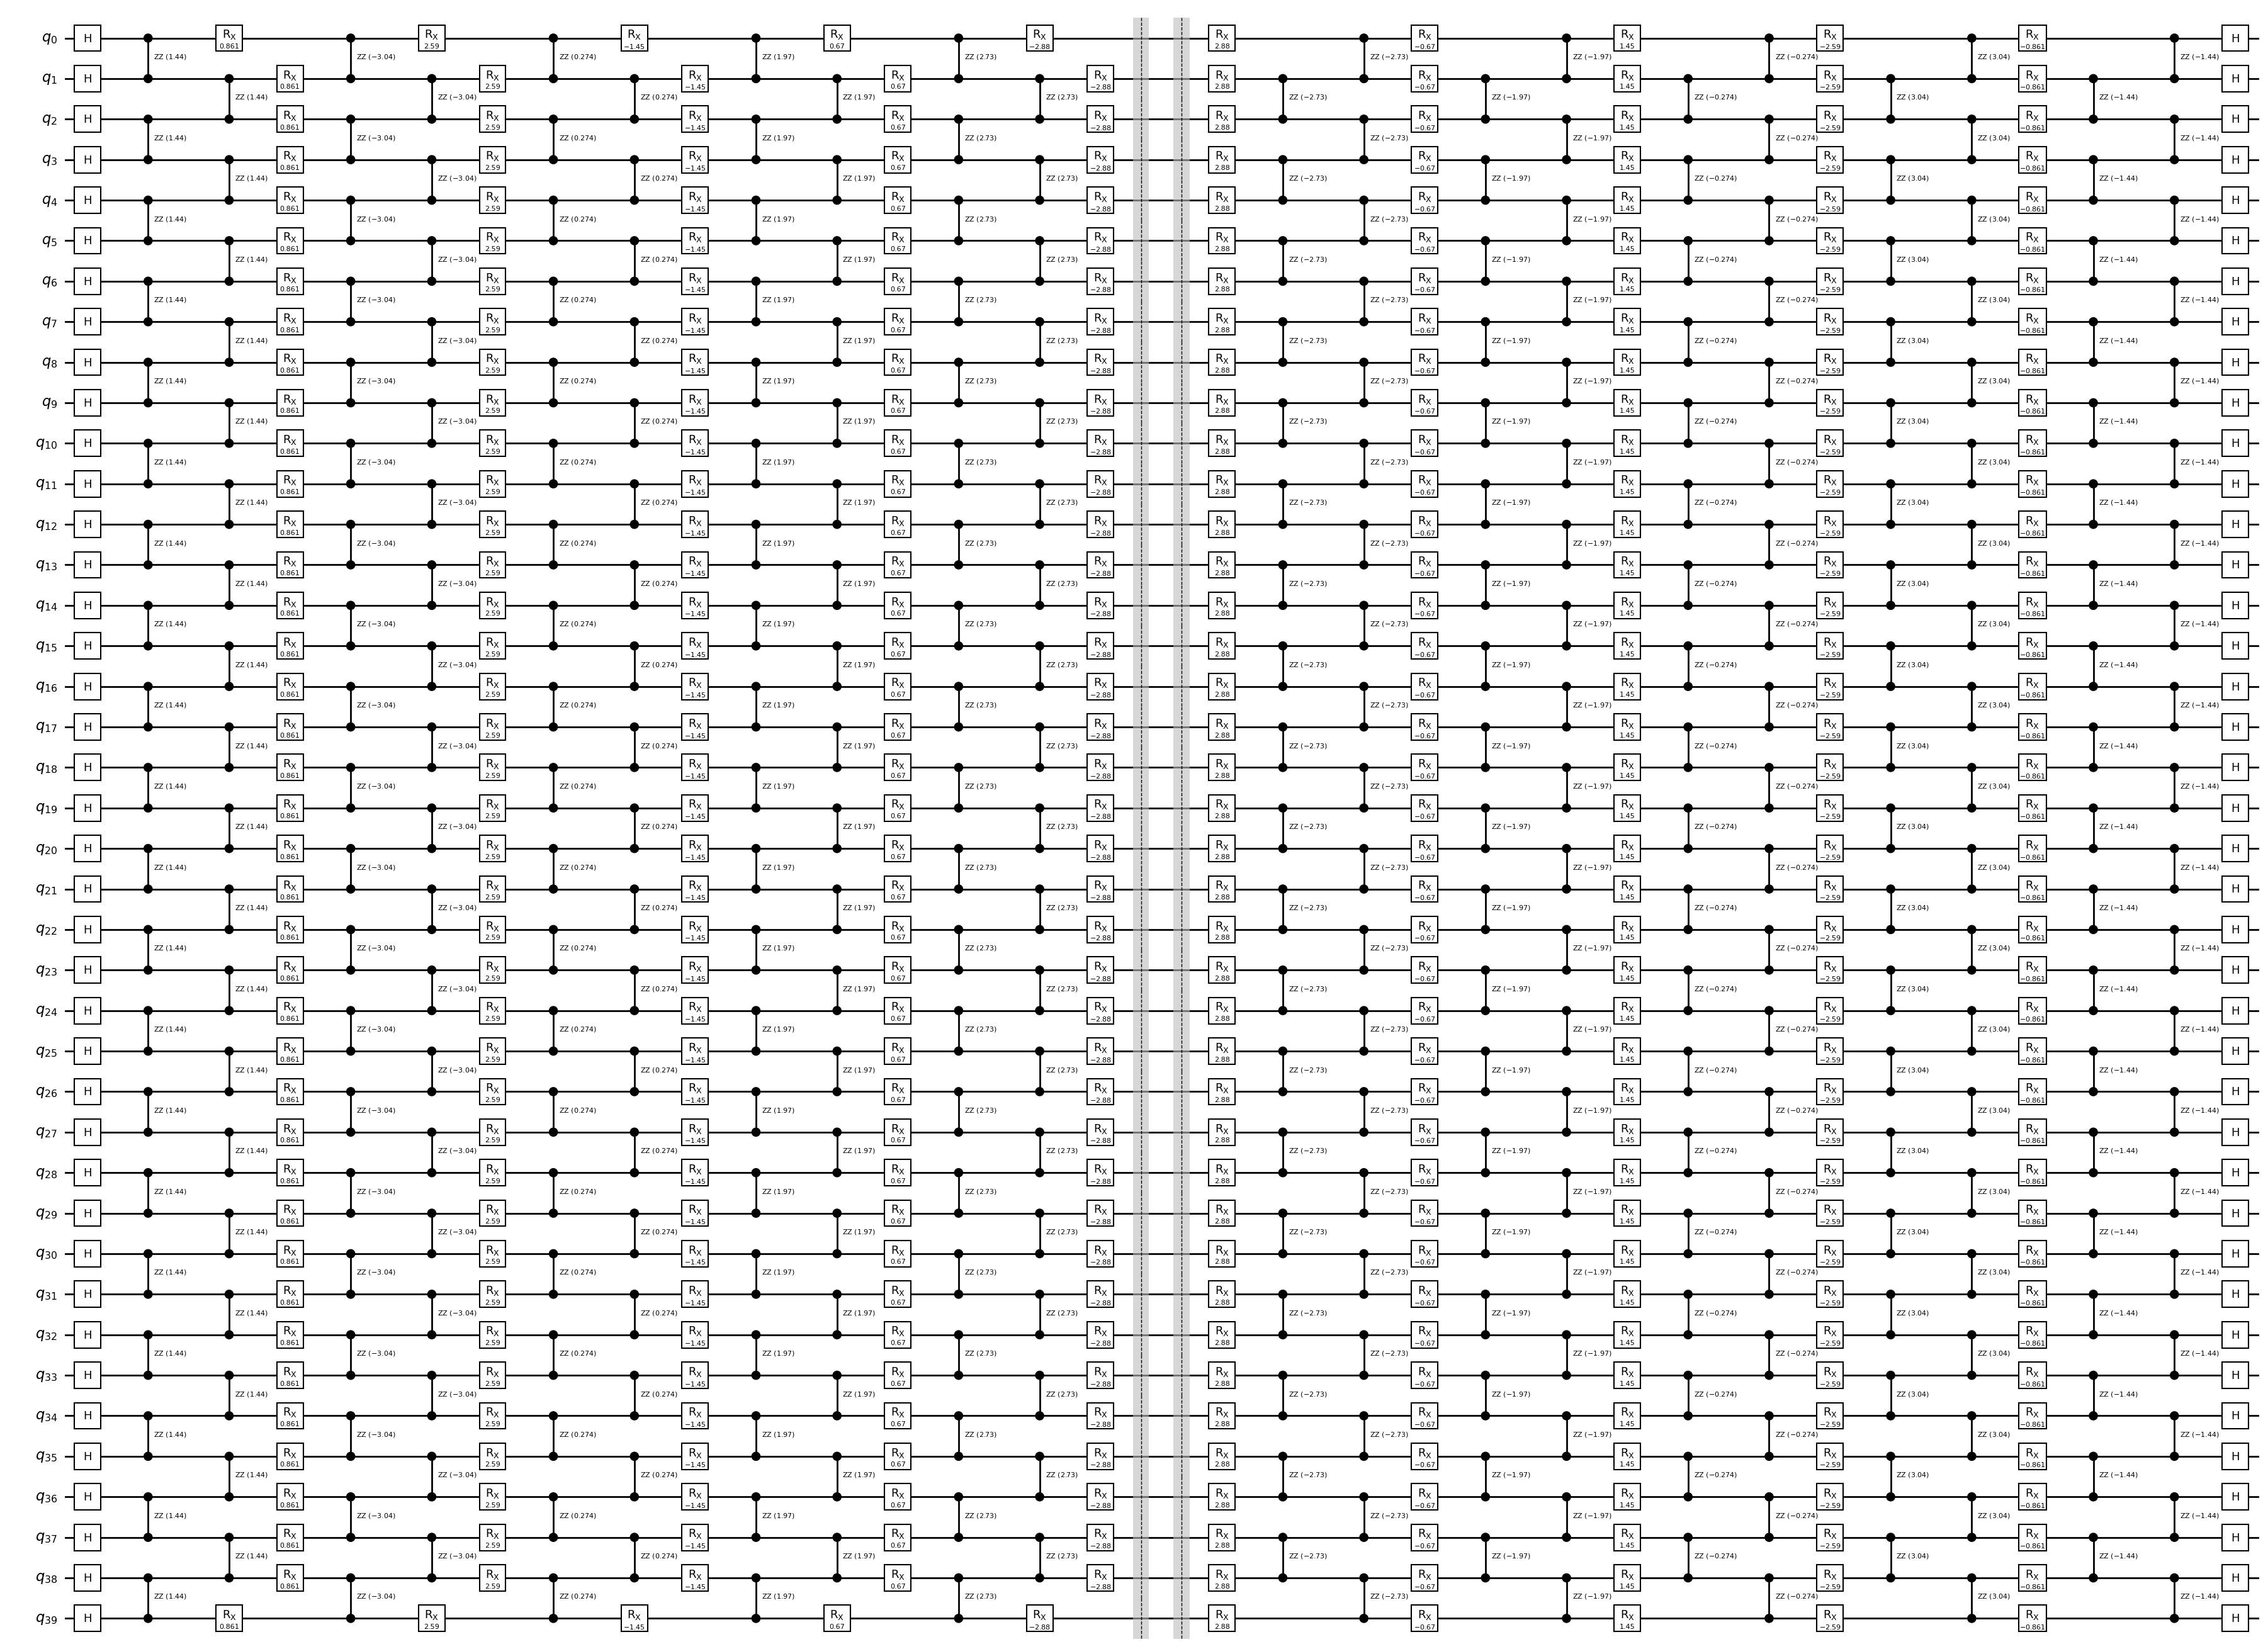

In [8]:
virtual_circuit.barrier()
virtual_circuit = UnitaryOverlap(virtual_circuit, virtual_circuit)

virtual_circuit.draw("mpl", style="bw", fold=-1)

We shall keep track of the 2-qubit depth of the compute-uncompute virtual circuit

In [9]:
print(f'2-qubit depth of the circuit is {virtual_circuit.depth(adds_two_qubit_depth)}')

2-qubit depth of the circuit is 20


#### Select backend

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', instance='quantum-demonstrations/main/summit-pf')

In [11]:
backend = service.get_backend('ibm_pinguino1')

### 2. Optimize circuits and observables

#### Transpile the circuit

It is useful to transpile the circuit before folding. This will ensure that the folded circuits are already transpiled.

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [13]:
transpiled_circuit = pm.run(virtual_circuit)

Note that each $R_{ZZ}$ gate in the circuit, when transpiled, leads to two ECR gates. This doubles the depth of the transpiled circuit. Therefore, now we have a circuit of 2-depth 40 (pre-transpilation 2-qubit depth was 20). Thus this is a $40 \times 40$ circuit.

In [14]:
print(f'2-qubit depth of the transpiled circuit is {transpiled_circuit.depth(adds_two_qubit_depth)}')

2-qubit depth of the transpiled circuit is 40


#### Apply layout to the observables

For this study, we select the observable to be the average of all weight-1 Z type operators.

In [15]:
from qiskit.quantum_info import SparsePauliOp

observable = ['I'*i + 'Z' + 'I'*(virtual_circuit.num_qubits-i-1) for i in range(virtual_circuit.num_qubits)]
observable = SparsePauliOp(observable, coeffs=[1/virtual_circuit.num_qubits]*len(observable))
observable

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIII

When the circuit is transpiled, the layout of the qubits is changed as per the transpilation process. Therefore, it is necessary to ensure that the observables are also modified as per the transpilation layout.

In [16]:
transpiled_observable = observable.apply_layout(transpiled_circuit.layout, num_qubits=backend.num_qubits)

### 3. Execute using a Qiskit Primitive

In general, $\lambda \in \mathbb{Z}$, and the most default values of $\lambda$ used for ZNE are $\{1,3,5\}$. However, we note that the above circuit has a 2-qubit depth of 40. Therefore, folding it with $\lambda = 5$ will create a circuit with 2-qubit depth of 200. The signal obtained from such a deep circuit may not be reliable enough for faithful extrapolation. Therefore, we shift to partial folding, where $\lambda \in \mathbb{R}$. In particular, we shall use $\lambda = \{1,1.2,1.4\}$.

$\lambda = 1.2$ implies that 2 out of 10 gates are selected randomly for folding. Below we show an example of this using the <a href='https://github.com/qiskit-community/prototype-zne/tree/main'>prototype-zne</a> package. Note that for the rest of the notebook, we shall use EstimatorV2 from Qiskit Runtime to apply ZNE. This is simply for better visualization.

In [17]:
from zne.noise_amplification import TwoQubitAmplifier

noise_amplifier = TwoQubitAmplifier(sub_folding_option='random', random_seed=0)

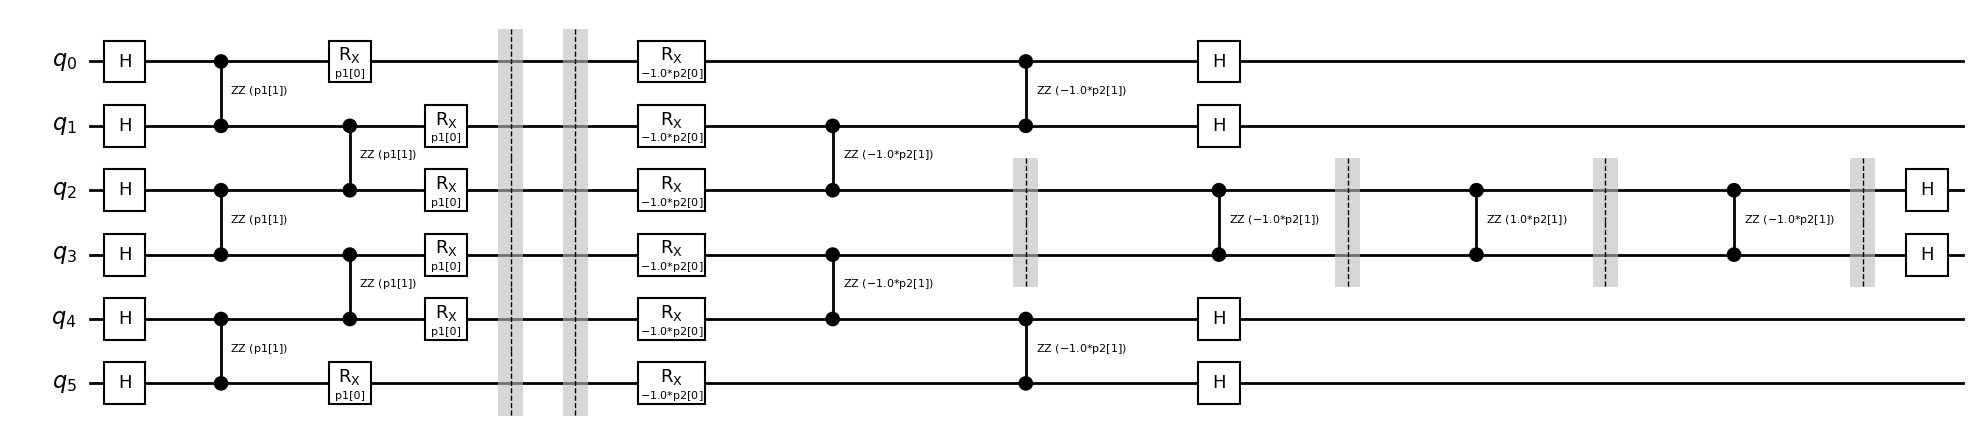

In [18]:
reference_folded_circuit = noise_amplifier.amplify_circuit_noise(reference_circuit, 1.2)
reference_folded_circuit.draw('mpl', style='bw', fold=-1)

Note that in the above example, only one $R_{ZZ}$ gate has been folded three times. Therefore, the folded circuit now contains 12 2-qubit gates, whereas the number of 2-qubit gates in the original reference circuit was 10.

The original 2-qubit depth of the reference circuit was 4. We can verify the 2-qubit depth of this folded circuit.

In [19]:
print(f'2-qubit depth of the folded circuit with \lambda = 1.2 is {reference_folded_circuit.depth(adds_two_qubit_depth)}')

2-qubit depth of the folded circuit with \lambda = 1.2 is 6


We leave it to the readers to verify that $\lambda = 3$ and $\lambda = 5$ would have produced a folded circuit with 2-qubit depths 12 and 20 respectively. Thus, partial folding results in significantly lower increase in depth when folded.

#### Create the Estimator object and set its options

We shall create an estimator object for this study. In order to get the results corresponding to partial folding alone, we shall disable other error mitigation and suppression options such as measurement error mitigation and dynamical decoupling. However, for a general experiment, it may be more prudent to enable other mitigation and suppression methods.

In [46]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=backend)
estimator.options.default_shots = 10000

# first we disable other mitigation options
estimator.options.resilience_level = 0
estimator.options.dynamical_decoupling.enable = False
estimator.options.twirling.enable_gates = False
estimator.options.twirling.enable_measure = False
estimator.options.resilience.measure_mitigation=False

# now we set the parameters for ZNE
estimator.options.resilience.zne_mitigation=True
estimator.options.resilience.zne.extrapolator='linear'
estimator.options.resilience.zne.noise_factors = [1,1.2,1.4]

#### Execute using the estimator

In [21]:
job_partial = estimator.run([(transpiled_circuit, transpiled_observable)])

### Step 4: Postprocess and Analyze

Now we can find the extrapolated expectation value.

In [22]:
result_partial = job_partial.result()[0]

In [33]:
mean_partial_mitigated = result_partial.data.evs
std_partial_mitigated = result_partial.data.stds

In [36]:
print(f'Mitigated expectation value with partial folding is {mean_partial_mitigated} +/- {std_partial_mitigated}')

Mitigated expectation value with partial folding is 0.6998237438506633 +/- 0.12684126427220854


We note that the mitigated expectation value is $\sim 0.7$, which is quite close to the ideal expectation value of $1$. The mitigated expectation value can be further improved by turning on measurement error mitigation, twirling, dynamical decoupling etc. We refrain from using higher order extrapolators for this example since it is shown that linear extrapolators are often sufficient with partial folding, showing better accuracy than higher-order extrapolators. Furthermore, linear extrapolators are known to be more stable than higher order extrapolators as well. Refer to the paper <a href="https://ieeexplore.ieee.org/abstract/document/10313813/">Best Practices for Quantum Error Mitigation with Digital Zero-Noise Extrapolation</a> for a detailed study on applying dZNE on problems of varying depth and qubit count.

### Cross-verify

Let us cross verify that using partial folding indeed provides better extrapolated expectation value than the usual ZNE folding with $\lambda \in \{1,3,5\}$. For this, we rerun the QAOA circuit with these values of $\lambda$ and obtain the extrapolated expectation value.

For this, we use both the linear and the exponential extrapolator to verify whether for any of these the mitigated expectation value can be as good as, or better than partial folding.

In [29]:
from qiskit_ibm_runtime import Batch
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.default_shots = 10000

# first we disable other mitigation options
options.resilience_level = 0
options.dynamical_decoupling.enable = False
options.twirling.enable_gates = False
options.twirling.enable_measure = False
options.resilience.measure_mitigation=False

# now we set the parameters for ZNE
estimator.options.resilience.zne_mitigation=True
estimator.options.resilience.zne.noise_factors = [1,3,5]

In [30]:
jobs = {}
with Batch(backend=backend) as batch:
    estimator = EstimatorV2(session=batch, options=options)

    # Linear extrapolation
    extrapolator = 'linear'
    estimator.options.resilience.zne.extrapolator = extrapolator
    jobs[extrapolator] = estimator.run([(transpiled_circuit, transpiled_observable)])

    # Exponential extrapolation
    extrapolator = 'exponential'
    estimator.options.resilience.zne.extrapolator = extrapolator
    jobs[extrapolator] = estimator.run([(transpiled_circuit, transpiled_observable)])

In [31]:
results = {extrapolator: job.result()[0] for extrapolator, job in jobs.items()}

In [35]:
mean_linear_mitigated = results['linear'].data.evs
std_linear_mitigated = results['linear'].data.stds

mean_exp_mitigated = results['exponential'].data.evs
std_exp_mitigated = results['exponential'].data.stds

In [37]:
print(f'Mitigated expectation value with linear extrapolator without partial folding is {mean_linear_mitigated} +/- {std_linear_mitigated}')

Mitigated expectation value with linear extrapolator without partial folding is 0.2022550000000001 +/- 0.0015346512722765394


In [38]:
print(f'Mitigated expectation value with exponential extrapolator without partial folding is {mean_exp_mitigated} +/- {std_exp_mitigated}')

Mitigated expectation value with exponential extrapolator without partial folding is 0.207345 +/- 0.0015341147455454564


### Inference

These results clearly show how unreliable ZNE mitigation with $\lambda \in \mathbb{Z}$ can get for deep circuits. Therefore, it is always a good practice to shift to partial folding for computations involving large circuits.

It is still an open question at what depth it becomes better to shift to partial folding. However, a general approach can be to pre-calculate the depth of the folded circuit, and decide whether any reliable signal can be obtained from them. In the 6-qubit example with $reference circuit$, the depth is clearly low, and reliable signal can be obtained with $\lambda = 3$ or $\lambda = 5$. However, for the $40 \times 40$ circuit, the depth is clearly too high for obtaining any reliable signal with $\lambda = 3$ or $\lambda = 5$. Therefore, partial folding is a clear choice here.

In [49]:
import qiskit_ibm_runtime
import qiskit

print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")
print(f"qiskit version {qiskit.version.get_version_info()}")

qiskit runtime version 0.23.0
qiskit version 1.0.2
